In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import requests
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

mapbox_token = requests.get('https://api.mapbox.com/?access_token=myaccesstoken').text
px.set_mapbox_access_token(mapbox_token)

In [2]:
mapbox_token

'{"api":"mapbox"}'

In [3]:
dfmc = pd.read_csv('McDonald_s_Reviews.csv',encoding='latin-1')

In [4]:
dfmc.columns

Index(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')

In [5]:
fig = px.scatter_mapbox(dfmc, lat='latitude ', lon='longitude', color="rating_count",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10, opacity=0.4)
fig.update_coloraxes(colorscale = 'viridis'                                 
                  )

fig.update_layout(height=800, mapbox=dict(center=go.layout.mapbox.Center(lat=40.543138, lon=-111.69486)), mapbox_style = "carto-darkmatter")
fig.show()


In [6]:
dfmc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


<Axes: xlabel='rating', ylabel='count'>

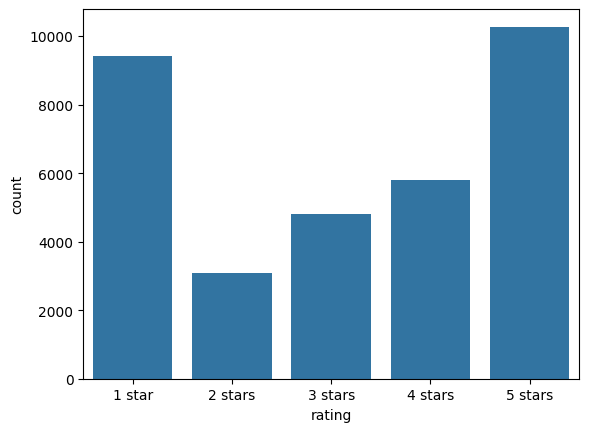

In [7]:
# count of ratings 
sns.countplot(data=dfmc, x=dfmc.rating, order=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])

In [8]:
dfmc.isnull().sum()

reviewer_id        0
store_name         0
category           0
store_address      0
latitude         660
longitude        660
rating_count       0
review_time        0
review             0
rating             0
dtype: int64

In [9]:
dfmc.duplicated().sum()

0

In [10]:
# convert rating from string to an int 
rating_map = {"1 star": 1,
              "2 stars": 2, 
              "3 stars": 3, 
              "4 stars": 4,
              "5 stars": 5
             }

dfmc['rating'] = dfmc['rating'].map(rating_map)
dfmc.head(5)

reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   
2            3  McDonald's  Fast food restaurant   
3            4  McDonald's  Fast food restaurant   
4            5  McDonald's  Fast food restaurant   

                                       store_address  latitude   longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
2  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
3  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
4  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   
1        1,240    5 days ago   
2        1,240    5 days ago   
3        1,240   a month ago   
4        1,240  2 months ago   

                                              review  rating  
0  Why does it look like someone spit on my food?...       1  
1  It'd McDonalds. It is what it is as far as the...       4  
2  Made a mobile order got to the speaker and che...       1  
3  My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...       5  
4  I repeat my order 3 times in the drive thru, a...       1

Cleaning & Preprocessing

In [11]:
# cleaning
import re
import string

def clean(review):
    review = review.lower()
    review = review.replace('ï', '')
    review = review.replace('¿', '')
    review = review.replace('½', '')
    review = review.replace('ý', '')
    review = " ".join(review.split())
    review = review.rstrip()
    return review

dfmc['clean_review'] = [clean(review) for review in dfmc['review']]
dfmc['clean_review'].head(20)

0     why does it look like someone spit on my food?...
1     it'd mcdonalds. it is what it is as far as the...
2     made a mobile order got to the speaker and che...
3     my mc. crispy chicken sandwich was customer se...
4     i repeat my order 3 times in the drive thru, a...
5     i work for door dash and they locked us all ou...
6     if i could give this location a zero on custom...
7     came in and ordered a large coffee w/no ice. t...
8     went thru drive thru. ordered. getting home no...
9     i'm not really a huge fan of fast food, but i ...
10                                       worst mcdonald
11    we stopped by for a quick breakfast. it was no...
12    the morning crew seems fast and efficient. nig...
13    today, i was disappointed in that restaurant #...
14    ordered food burger wrong and left out part of...
15    this was a dine in experience. the tables were...
16    the line ws extremely big and was moving very ...
17    the boy who attended me made me wait and w

Clustering text similarity

We create a list of TF-IDF for each rating label and a dictionary for the vocabuluary of each rating. Then we examine the top-ranked words determined by the summed TF-IDF.

O TfidfVectorizer é uma técnica de processamento de texto que é frequentemente usada para converter documentos de texto em representações numéricas adequadas para análise de máquina. A sigla TF-IDF significa "Term Frequency-Inverse Document Frequency," que se refere a uma pontuação que é atribuída a cada palavra em um documento com base em sua frequência no documento (TF) e em sua importância em relação a todos os documentos no corpus (IDF). O objetivo do TF-IDF é destacar as palavras mais importantes em um documento em relação a um conjunto de documentos.

Aqui está uma explicação mais detalhada dos componentes do TF-IDF:

Term Frequency (TF): Refere-se à frequência com que uma palavra ocorre em um documento específico. Geralmente, é calculada como o número de vezes que uma palavra aparece dividido pelo número total de palavras no documento. O TF mede a importância relativa de uma palavra em um documento.

Inverse Document Frequency (IDF): Refere-se à importância de uma palavra em relação a um conjunto de documentos (corpus). O IDF é calculado como o logaritmo do inverso da frequência com que uma palavra aparece em todos os documentos do corpus. O IDF penaliza palavras que aparecem em muitos documentos e dá um peso maior às palavras raras que são únicas ou ocorrem apenas em poucos documentos.

In [12]:
# create tf-idf and vocab list for each rating 
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_list = []
tfidf_vocab = {}


for rating in sorted(dfmc.rating.unique()):
    tfidf_list.append(tfidf_vectorizer.fit_transform(dfmc[dfmc.rating == rating].clean_review))
    tfidf_vocab[rating] = tfidf_vectorizer.get_feature_names_out()

[print(f'\nRating: {rating} stars', '\nTFIDF array: ', tfidf.toarray(), '\nVocab list: ', tfidf_vocab[rating]) for rating, tfidf in zip(sorted(dfmc.rating.unique()), tfidf_list)]


Rating: 1 stars 
TFIDF array:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
Vocab list:  ['00' '000' '0000000' ... 'zombies' 'zone' 'zoo']

Rating: 2 stars 
TFIDF array:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
Vocab list:  ['00' '00am' '01' ... 'yummy' 'zero' 'zoo']

Rating: 3 stars 
TFIDF array:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
Vocab list:  ['00' '01' '02' ... 'zero' 'zone' 'zoo']

Rating: 4 stars 
TFIDF array:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
Vocab list:  ['00' '00pm' '10' ... 'yummy' 'yup' 'zoo']

Rating: 5 sta

[None, None, None, None, None]

In [13]:
# examining top-ranked words in 2 stars 
df_rank = pd.DataFrame({'Words': tfidf_vocab.get(2), 'Summed TFIDF': tfidf_list[1].toarray().sum(axis=0)}).sort_values('Summed TFIDF', ascending=False)
df_rank.head(20)

Words  Summed TFIDF
2996      poor    329.160506
1581      food    117.616626
3497   service    104.142069
2780     order     98.940030
3619      slow     88.369899
2448  mcdonald     68.059931
1262     drive     66.694328
1734      good     59.773835
4040      time     51.700115
2282      like     48.875466
4476     wrong     47.975471
806       cold     47.576325
2156      just     46.267124
1160     dirty     46.178997
2954     place     46.075391
2901    people     45.656012
2330      long     45.447340
1646     fries     43.251950
404        bad     40.763510
1740       got     40.680365

Dimensionality reduction to perform all-by-all cosine similarities (TruncatedSVD)

We use TruncatedSVD dimensionality reduction to allow us to perform all-by-all cosine similarities, which improves our metric for similarity between reviews, and allow for better clustering using K-Means.

O TruncatedSVD (Singular Value Decomposition Truncated) é uma técnica de redução de dimensionalidade que é frequentemente aplicada a matrizes esparsas ou densas. Ela é usada para reduzir o número de características (ou dimensões) em um conjunto de dados, enquanto mantém o máximo de informações possível.

O TruncatedSVD é uma variação da SVD (Decomposição de Valor Singular) regular que calcula apenas um número especificado de componentes principais, em vez de calcular todos os componentes. Isso é especialmente útil quando você deseja reduzir a dimensionalidade de seus dados, economizando tempo de computação e evitando problemas de memória, o que pode ser um desafio com matrizes grandes.

In [14]:
# dimensionality reduction to perform all-by-all cosine similarities 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize


shrunk_norm_matrix_list = []

for tfidf in tfidf_list:
    shrunk_norm_matrix_list.append(normalize(TruncatedSVD(n_components=100).fit_transform(tfidf)))
    
cosine_similarity_matrix = [shrunk_norm_matrix @ shrunk_norm_matrix.T for shrunk_norm_matrix in shrunk_norm_matrix_list]
cosine_similarity_matrix

[array([[ 1.        ,  0.09435125,  0.03386654, ...,  0.01649299,
         -0.01352354,  0.08524168],
        [ 0.09435125,  1.        ,  0.06915371, ...,  0.01533613,
         -0.02422342,  0.13049523],
        [ 0.03386654,  0.06915371,  1.        , ...,  0.07330899,
          0.13477284,  0.07407763],
        ...,
        [ 0.01649299,  0.01533613,  0.07330899, ...,  1.        ,
          0.65853659,  0.14147729],
        [-0.01352354, -0.02422342,  0.13477284, ...,  0.65853659,
          1.        ,  0.08687702],
        [ 0.08524168,  0.13049523,  0.07407763, ...,  0.14147729,
          0.08687702,  1.        ]]),
 array([[ 1.00000000e+00,  5.88177855e-02,  5.45841237e-02, ...,
          2.17159998e-01,  6.80254404e-02,  4.12925387e-03],
        [ 5.88177855e-02,  1.00000000e+00, -2.40272621e-03, ...,
          4.26784674e-03, -2.03325214e-02,  5.77559094e-03],
        [ 5.45841237e-02, -2.40272621e-03,  1.00000000e+00, ...,
         -2.09743227e-02,  1.19399633e-02, -1.00603742e-

Optimization of K parameter in KMeans using an Elbow Plot

We generate an elbow plot of k values ranging from 1 to 61. MiniBatchKMeans is chosen for generating the elbow plot rather than KMeans to reduce runtime.

O MiniBatchKMeans é um algoritmo de clusterização que é uma variação do algoritmo K-Means tradicional, projetado para funcionar com grandes conjuntos de dados, economizando recursos computacionais e, portanto, sendo mais rápido para treinamento e clusterização.

O K-Means é um algoritmo de aprendizado não supervisionado que agrupa os dados em clusters com base na proximidade dos pontos de dados aos centróides. No entanto, o K-Means tradicional pode ser computacionalmente intensivo, especialmente em conjuntos de dados muito grandes, pois requer que todos os pontos de dados sejam avaliados em cada iteração.

O MiniBatchKMeans resolve esse problema dividindo o conjunto de dados em lotes (mini-batches) menores e, em seguida, atualizando os centróides com base nesses lotes. Isso o torna muito mais eficiente em termos de memória e velocidade, embora a qualidade dos clusters possa ser ligeiramente afetada em comparação com o K-Means tradicional.

In [15]:
# elbow curve function
from sklearn.cluster import MiniBatchKMeans
import time

np.random.seed(0)
def generate_elbow_plot(matrix_list):
    start_time = time.time()
    for index, matrix in enumerate(matrix_list):
        k_values = range(1, 61)
        inertia_values = [MiniBatchKMeans(k).fit(matrix).inertia_ for k in k_values]
        plt.plot(k_values, inertia_values, label=[f'{index+1} star'])
        plt.xlabel('K')
        plt.ylabel('Inertia')
        plt.grid(True)
        plt.legend()
    plt.show()
    return print(f'{round(time.time() - start_time)} seconds')

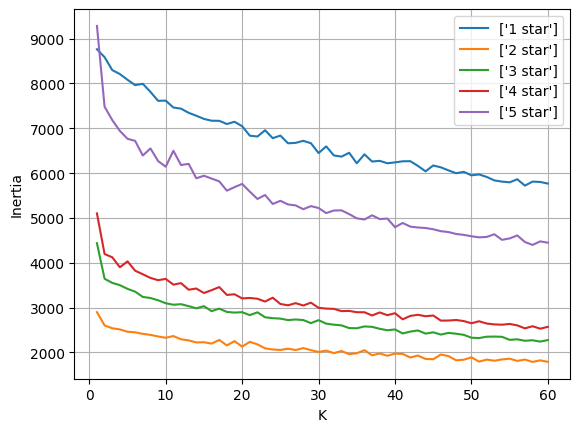

73 seconds


In [16]:
import warnings
warnings.filterwarnings("ignore")

# elbow curve of all ratings
generate_elbow_plot(shrunk_norm_matrix_list)

From the elbow plot it is difficult to determine the optimal k parameter value, however, we can start with a k value of 10 and then investigate the effect of a k value of 5 and 15.

KMeans Clustering & Wordclouds (K = 10)

We perform KMeans clustering on the reviews at each different rating with a k value of 10. We then create wordclouds of the top ranked words (determined by summed TF-IDF) for each rating to ideally gain insight on precise words used in customers feedback.

In [17]:
# function that creates KMeans for reviews
from sklearn.cluster import KMeans

def compute_cluster_groups(shrunk_norm_matrix, k=10, review=dfmc['clean_review']):
    cluster_model = KMeans(n_clusters=k, random_state=42)
    clusters = cluster_model.fit_predict(shrunk_norm_matrix)
    df = pd.DataFrame({'Index' : range(clusters.size), 'Cluster' : clusters, 'Review' : review})
    return [df_cluster for _, df_cluster in df.groupby('Cluster')]

In [18]:
# computes clusters for each seperate rating 
cluster_groups = []

for index, rating in enumerate(sorted(dfmc.rating.unique())):
    cluster_groups.append(compute_cluster_groups(shrunk_norm_matrix_list[index], review=dfmc[dfmc.rating == rating].clean_review))
    
print([("For: ", rating, "\n", cluster_groups[index]) for index, rating in enumerate(sorted(dfmc.rating.unique()))])

[('For: ', 1, '\n', [       Index  Cluster                                             Review
5          3        0  i work for door dash and they locked us all ou...
12         8        0  the morning crew seems fast and efficient. nig...
24        15        0                          didnt take card. but didn
25        16        0  mcdonalds is proud to own the most broken ice ...
35        22        0  this location is a horrible store to work for....
...      ...      ...                                                ...
33322   9414        0                          1 hour for two hamburgers
33341   9419        0   very, very time consuming to deliver the snacks.
33346   9421        0  attitude of the managers as if she were the ow...
33349   9423        0                   no good unhealthy dirty bathroom
33391   9430        0                        they treated me very badly.

[2688 rows x 3 columns],        Index  Cluster                                             Review
28  

In [19]:
# cluster 0 in 1 stars
cluster_groups[0][0]

Index  Cluster                                             Review
5          3        0  i work for door dash and they locked us all ou...
12         8        0  the morning crew seems fast and efficient. nig...
24        15        0                          didnt take card. but didn
25        16        0  mcdonalds is proud to own the most broken ice ...
35        22        0  this location is a horrible store to work for....
...      ...      ...                                                ...
33322   9414        0                          1 hour for two hamburgers
33341   9419        0   very, very time consuming to deliver the snacks.
33346   9421        0  attitude of the managers as if she were the ow...
33349   9423        0                   no good unhealthy dirty bathroom
33391   9430        0                        they treated me very badly.

[2688 rows x 3 columns]

In [20]:
from wordcloud import WordCloud

def cluster_to_wordcloud(cluster_group, max_words=10):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(cluster_group)
    vocab_list = vectorizer.get_feature_names_out()
    
    # create a rank list of words
    df_ranked = pd.DataFrame({'Word' : vocab_list, 'Sum TFIDF': tfidf_matrix.toarray().sum(axis=0)}).sort_values('Sum TFIDF', ascending=False)
    
    # create word score
    word_to_score = {word: score for word, score in df_ranked[:max_words].values}
    
    # initialize wordcloud object
    wordcloud_generator = WordCloud(background_color='white')

    # fit wordcloud_generator to word_to_score
    wordcloud_image = wordcloud_generator.fit_words(word_to_score)
    
    return wordcloud_image

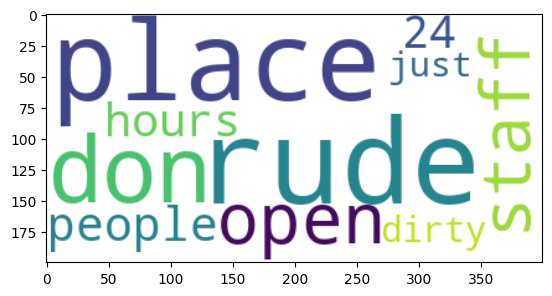

In [21]:
# wordcloud of the first cluster for 1 star reviews
wordcloud_image = cluster_to_wordcloud(cluster_groups[0][0].Review)
plt.imshow(wordcloud_image, interpolation='bilinear')

In [22]:
def grid_wordcloud(cluster_groups, rating_num, max_words=10, rows=5, columns=2, figsize=(10,10)):
    rating_list = []
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    for index, cluster in enumerate(cluster_groups):
        row = index // columns
        column = index % columns
        wordcloud_image = cluster_to_wordcloud(cluster_groups[index].Review, max_words)
        ax[row][column].imshow(wordcloud_image, interpolation='bilinear')
        ax[row][column].set_title(f'Cluster: {index}')
        ax[row][column].set_xticks([])
        ax[row][column].set_yticks([])
    fig.suptitle(f"{rating_num}:", fontsize=20)

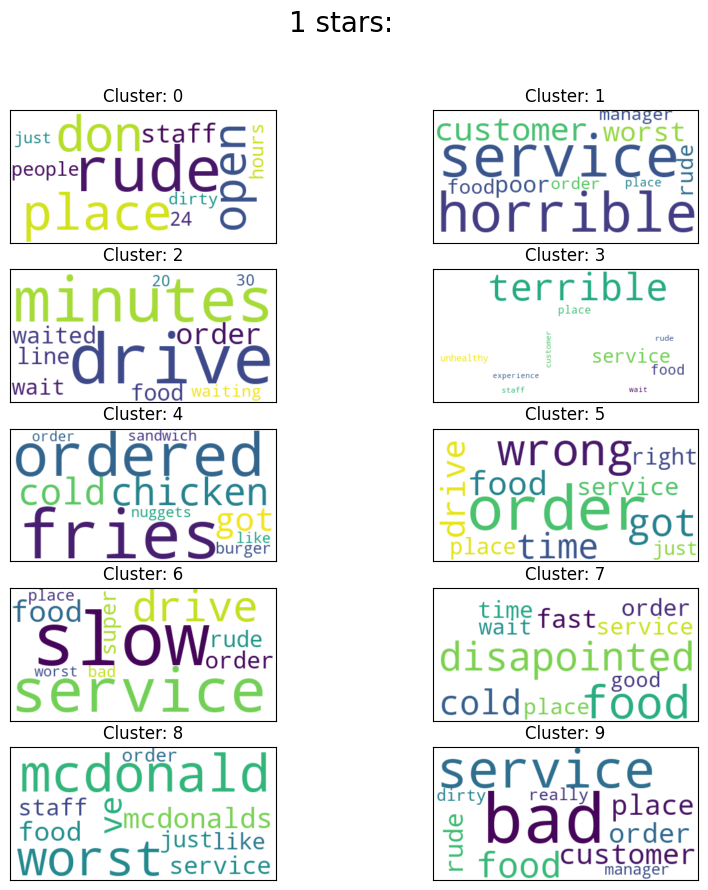

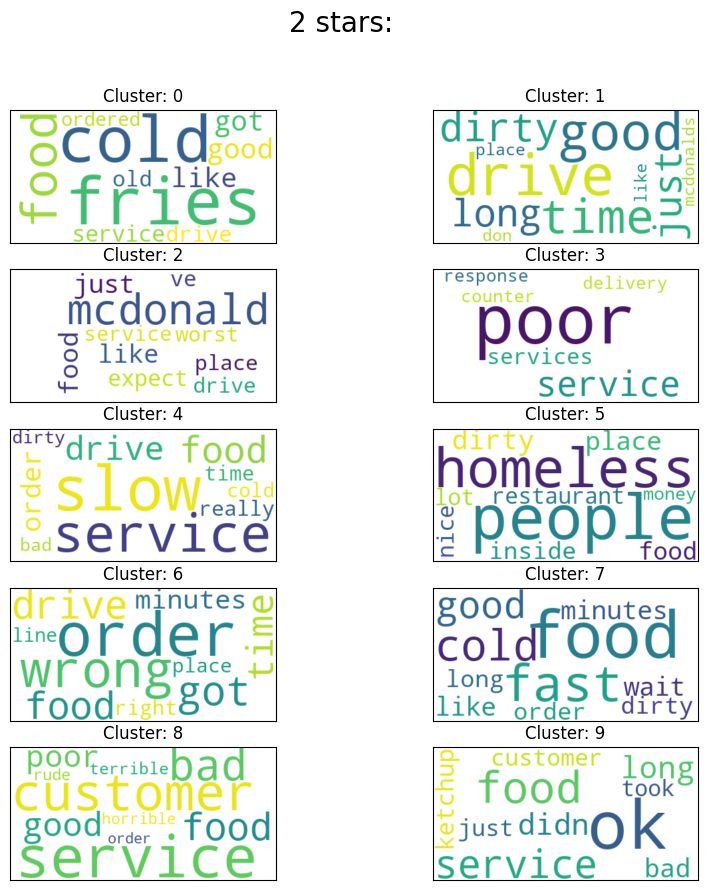

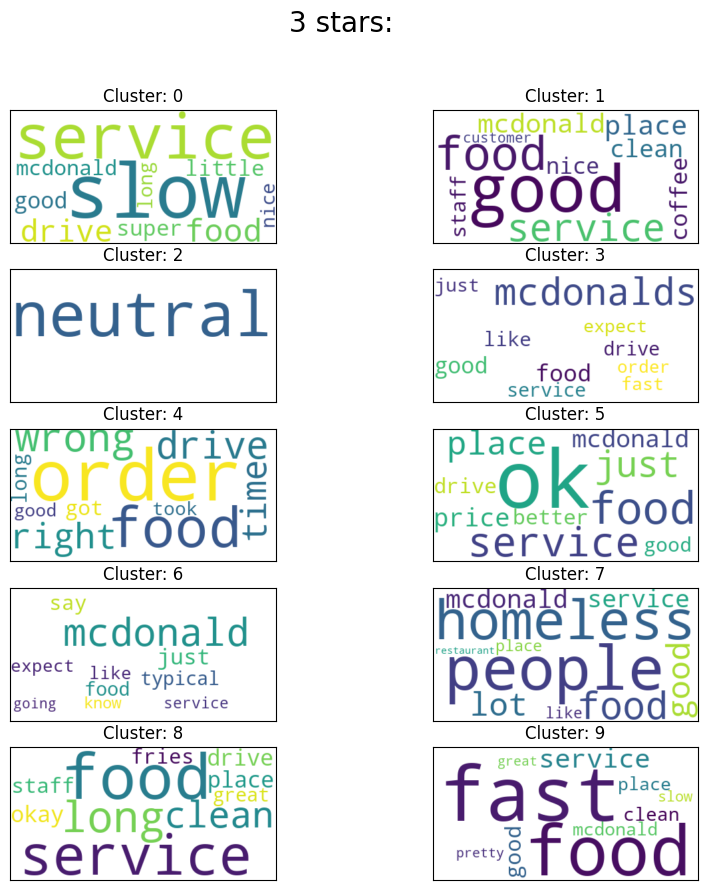

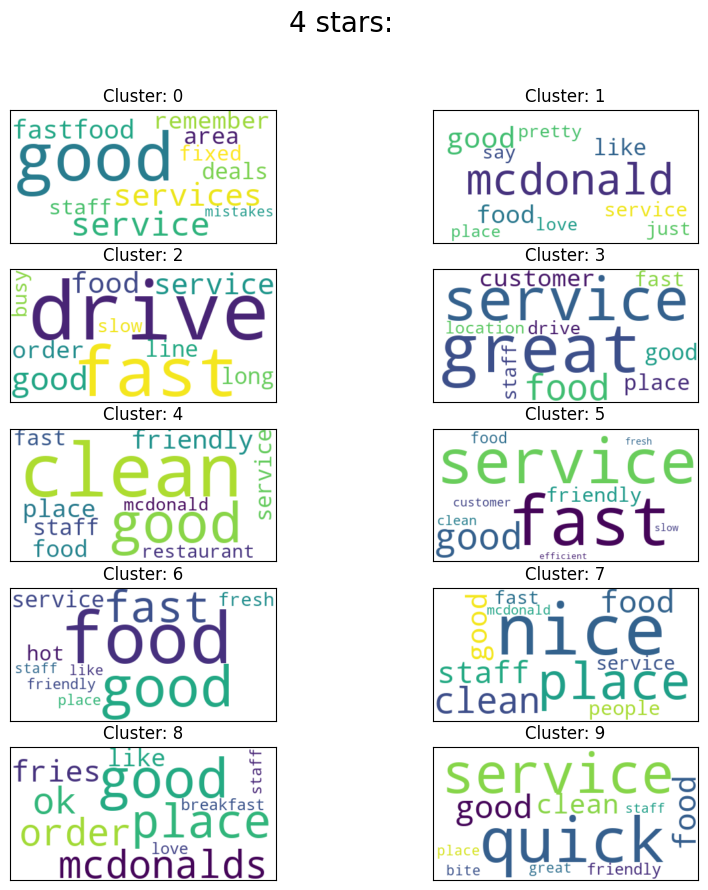

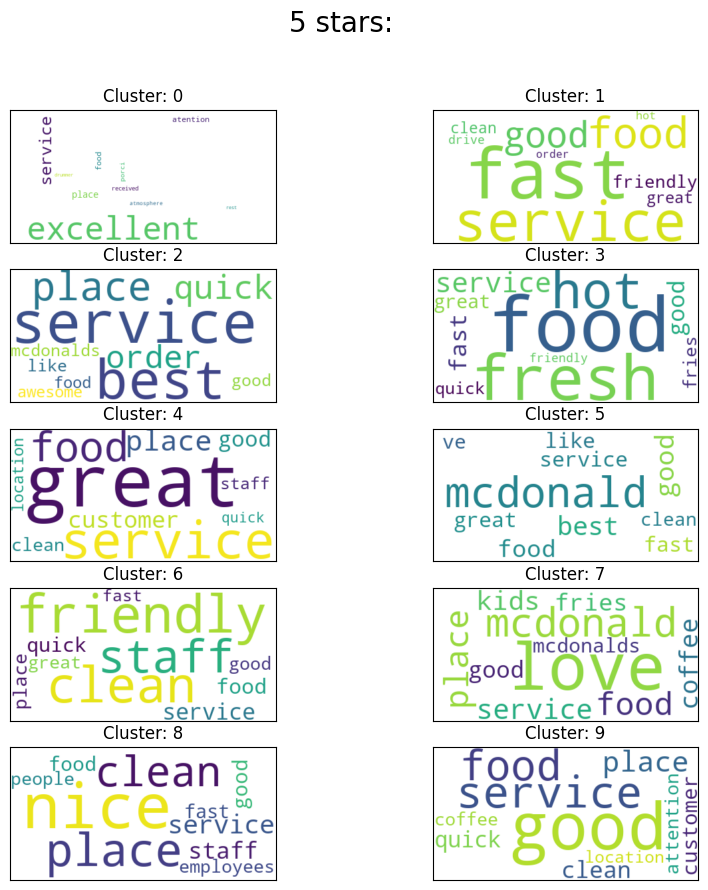

In [23]:
# all clusters wordclouds for each rating
for index, rating in enumerate(sorted(dfmc.rating.unique())):
    grid_wordcloud(cluster_groups[index], rating_num=f'{rating} stars')

Interpretation of WordClouds (K = 10)
1 star ratings:

Cluster 0: Stores that might claim that their store is open 24 hours for drive-through, are actually not open 24 hours.
Cluster 1: Cold food (specifically fries), long waiting time for their order, and horrible service.
Cluster 2: Poor service, rude staff and worst McDonald's store they've been to.
Cluster 3: Bad service, rude manager, dirty environment and issues with order.
Cluster 4: Rude staff/manager, bad fries and dirty environment.
Cluster 5: People were dissapointed, more specifically in regards to their order (how long it took) and rude service.
Cluster 6: Customer service was poor or the worst they've experienced, issues regarding drive-through, and slow service.
Cluster 7: People didn't enjoy their experience in regards to rude staff and service, and claim the food is unhealthy and overall terrible.
Cluster 8: People waited a long time (20-30 minutes) for their order in the drive-through.
Cluster 9: Poor service and received the wrong order which they waited a while for.

2 star ratings:

Cluster 0: Worst McDonalds/service/food but was what they expected.
Cluster 1: Fries and food got cold due to the slow service and potentially the food was not properly cooked.
Cluster 2: Poor service/delivery.
Cluster 3: Waited a long time in drive-through for their food due to potentially long lines.
Cluster 4: Customer service was rude but some people thought the food was ok.
Cluster 5: Bad service, dirty/bad food and order was either the wrong one or was slow.
Cluster 6: People got the wrong order and took awhile.
Cluster 7: Maybe some aspects were nice (although not clear what aspects exactly) but the store (more specifically potentially the tables) were dirty and there were homeless people inside the store.
Cluster 8: Reveived wrong order and took awhile.
Cluster 9: People didn't like the food and staff.

3 star ratings:

Cluster 0: People had a neutral feeling towards the store.
Cluster 1: It is unclear what was right or wrong (was it right time or right order or wrong time or wrong order?) but the staff was good.
Cluster 2: Wasn't clear what exactly was "nice"/"great" and what was just "okay"; but it seems to be positive in regards to the staff, service, food, and cleanliness.
Cluster 3: The store was busy, good prices and ok food or service.
Cluster 4: The food (more specifically the fries and the coffee) and service was good, and the store was clean.
Cluster 5: The wait for the food (specifically the lines in the drive-through) were long but potentially the food was good.
Cluster 6: The service, food and store was what they expected or typical, and wasn't anything special (although it isn't clear whether the word special was used in a negative tone, I assume it was as the rating was only 3 stars for a reason).
Cluster 7: It seems to have a mix sentiment for the food, people and overall McDonalds experience (some thought is was good and some didn't like).
Cluster 8: The service (maybe more specifically in the drive-through) was slow but nice, and the food was food. Some refered the store as super.
Cluster 9: Some people thought the service was slow and some thought the service was fast. Regardless people had a positive sentiment with considering the service good and friendly. In addition,the store was clean and pretty.

4 star ratings:

Cluster 0: The order came fast, the service was good, and the store was clean.
Cluster 1: This cluster is a bit unclear, however, the overall sentiment is positive and the service and staff was good with little mistakes.
Cluster 2: The food came fast, the food was good, and so was the service.
Cluster 3: The store was clean, food was pretty good and it came fast.
Cluster 4: People loved the food, and specifically the fries and breakfast, and the food came fast.
Cluster 5: People found the store, service, staff, and food nice. Furthermore, the place was clean and the order came fast.
Cluster 6: The service was good and friendly, and the order mostly came fast and quick. Also the store was clean.
Cluster 7: Service was considered good, the store was clean, the food came quick, and was fresh and hot.
Cluster 8: The service and staff was friendly, the food came fast, and the store was clean.
Cluster 9: The store was clean, the food came fast, and it seems there is mixed sentiment with the overall place and employees with some saying it is good/ncie and some saying it is ok.

5 star ratings:

Cluster 0: The service was friendly, the food came fast and was good. Some people claiming it was the best mcdonalds.
Cluster 1: Service was great, the order arrived fast, and the food was good and hot.
Cluster 2: Excellent service.
Cluster 3: People loved the service, food (spefically the fries) and coffee, and claimed it was kid friendly.
Cluster 4: Good and friendly service, food came quick, and people enjoyed the coffee.
Cluster 5: The staff was friendly, and the food came fast and was fresh and hot.
Cluster 6: Clean store, food came fast and good service.
Cluster 7: Service and staff was good and friendly. Some claiming it is the best McDonald's.
Cluster 8: Great fast service, clean restuarant, and friendly staff.
Cluster 9: Great and friendly service and great location.
Overall, it seems that although the clusters provide great insight, some of the clusters overlap and should be all in one cluster. For that reason, it seems unnecessary to investigate a k value higher than 10.

In [24]:
# computes clusters for each seperate rating with a cluster size of 5
cluster_groups = []

for index, rating in enumerate(sorted(dfmc.rating.unique())):
    cluster_groups.append(compute_cluster_groups(shrunk_norm_matrix_list[index], k=5, review=dfmc[dfmc.rating == rating].clean_review))
    
print([("For: ", rating, "\n", cluster_groups[index]) for index, rating in enumerate(sorted(dfmc.rating.unique()))])

[('For: ', 1, '\n', [       Index  Cluster                                             Review
2          1        0  made a mobile order got to the speaker and che...
4          2        0  i repeat my order 3 times in the drive thru, a...
6          4        0  if i could give this location a zero on custom...
14         9        0  ordered food burger wrong and left out part of...
20        12        0  can't believe experience with order taker. wen...
...      ...      ...                                                ...
33255   9386        0  terrible staff in general, i have never seen a...
33263   9391        0  as an uber driver and delivery person today 29...
33275   9398        0  i made an order through uber eat and it took m...
33296   9404        0  i ordered an order online i went to look for i...
33315   9413        0  they overcharged me and my order was not the o...

[1730 rows x 3 columns],        Index  Cluster                                             Review
5   

In [25]:
# cluster 0 in 1 stars
cluster_groups[0][0]

Index  Cluster                                             Review
2          1        0  made a mobile order got to the speaker and che...
4          2        0  i repeat my order 3 times in the drive thru, a...
6          4        0  if i could give this location a zero on custom...
14         9        0  ordered food burger wrong and left out part of...
20        12        0  can't believe experience with order taker. wen...
...      ...      ...                                                ...
33255   9386        0  terrible staff in general, i have never seen a...
33263   9391        0  as an uber driver and delivery person today 29...
33275   9398        0  i made an order through uber eat and it took m...
33296   9404        0  i ordered an order online i went to look for i...
33315   9413        0  they overcharged me and my order was not the o...

[1730 rows x 3 columns]

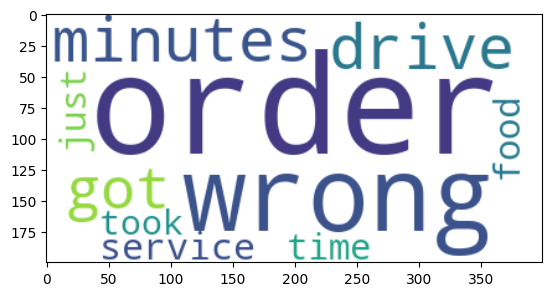

In [26]:
# wordcloud of the first cluster for 1 star reviews
wordcloud_image = cluster_to_wordcloud(cluster_groups[0][0].Review)
plt.imshow(wordcloud_image, interpolation='bilinear')

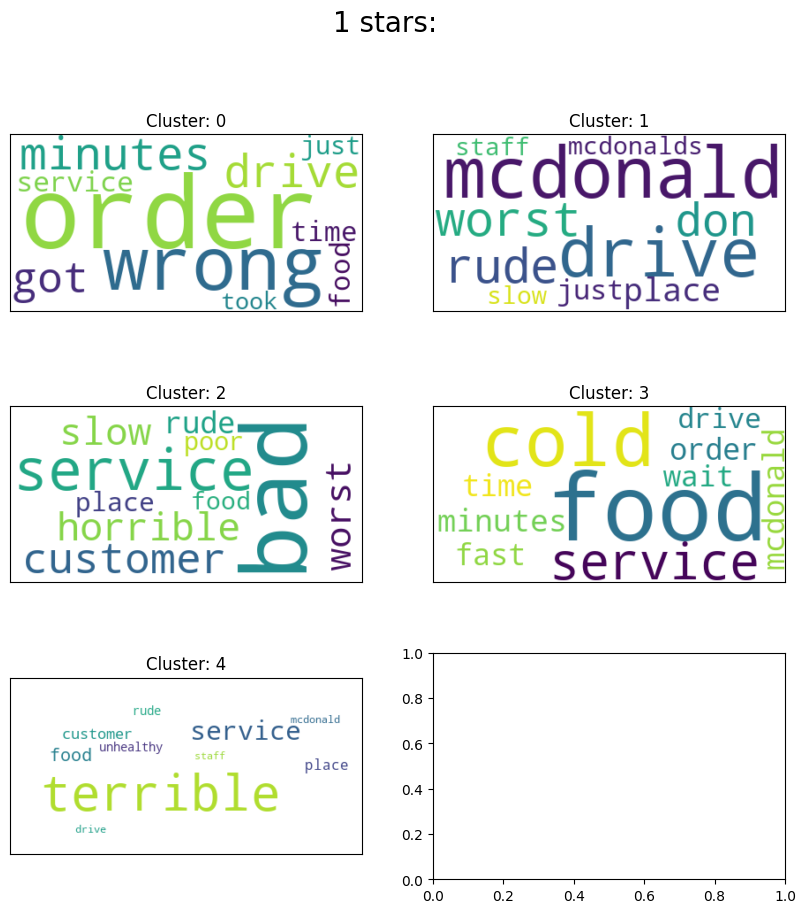

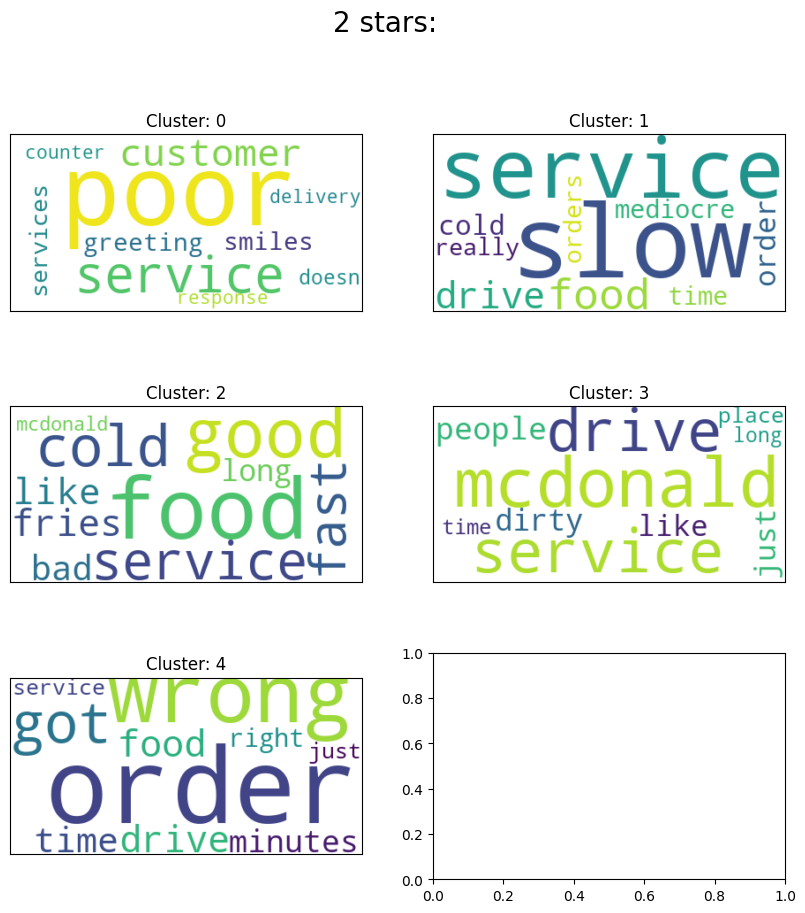

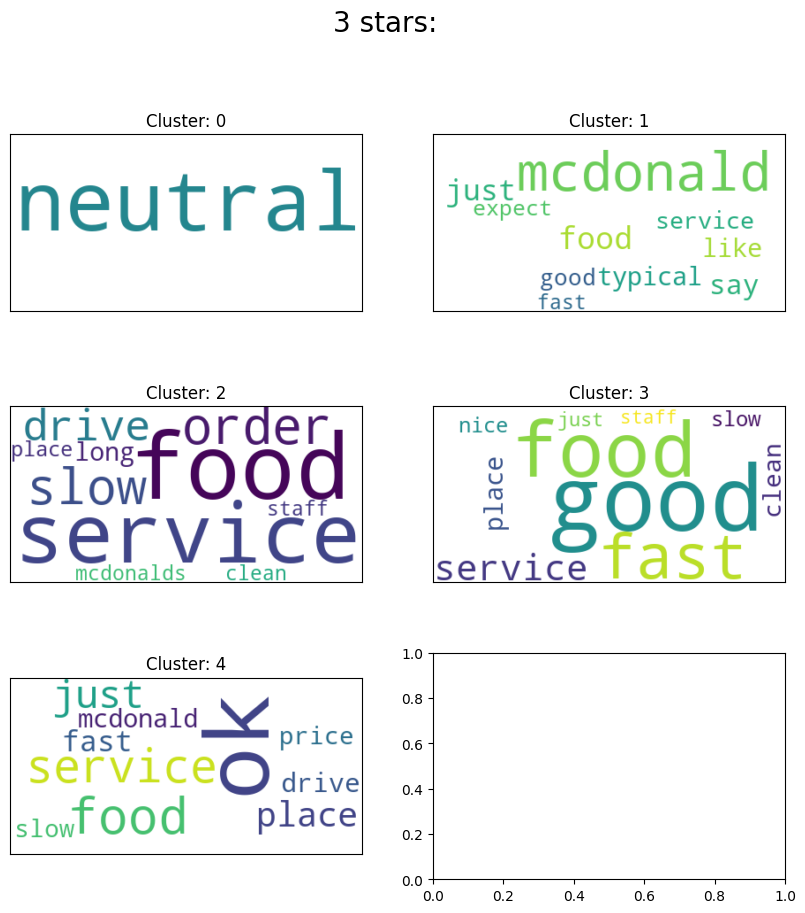

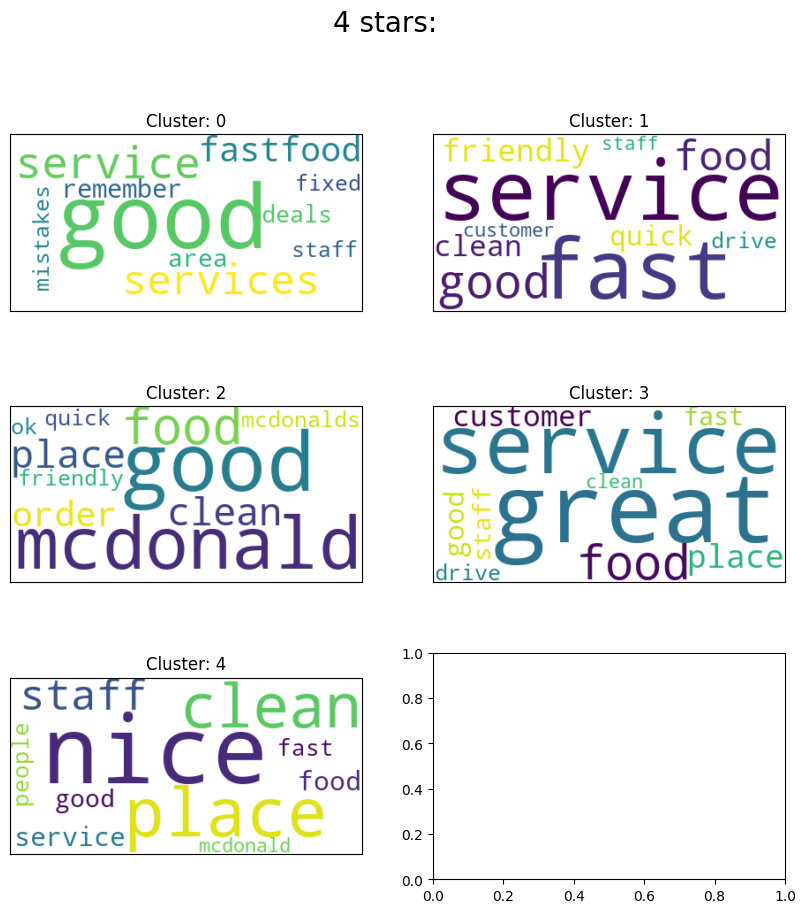

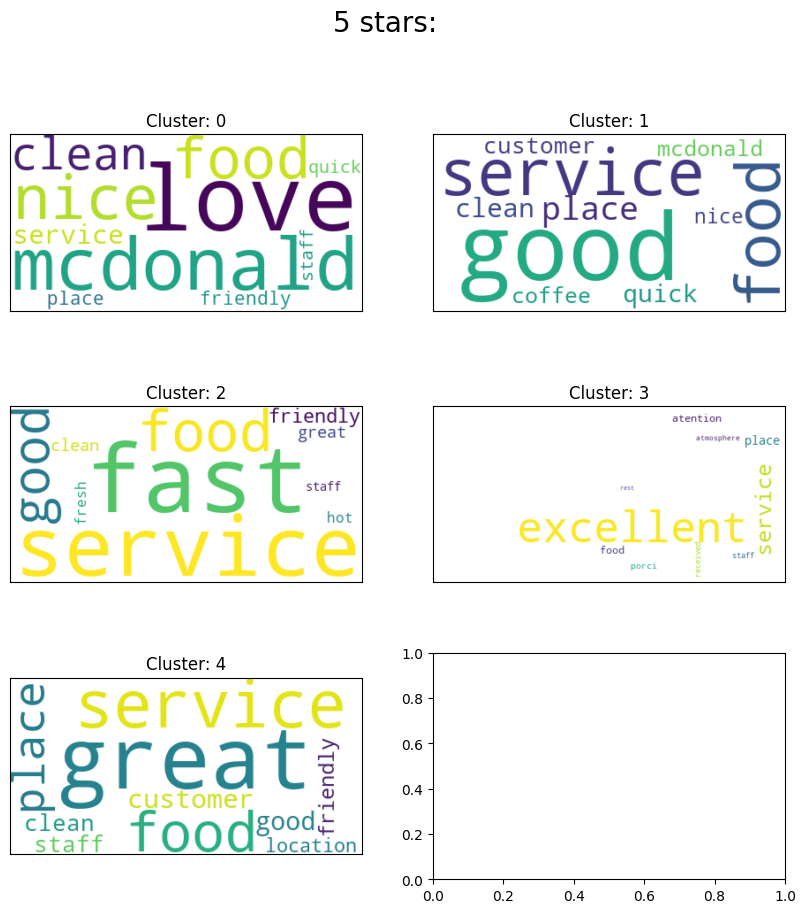

In [27]:
# all clusters wordclouds for each rating
for index, rating in enumerate(sorted(dfmc.rating.unique())):
    grid_wordcloud(cluster_groups[index], rating_num=f'{rating} stars', rows=3, columns=2)

Interpretation of WordCloud (K = 5)

1 star ratings:

Cluster 0: People received the wrong order and it took a long time to arrive.
Cluster 1: Slow service, had to wait for order, and the food came cold.
Cluster 2: Terrible service and food.
Cluster 3: People considered it to be the worst, the staff was rude, and the order was slow.
Cluster 4: Horrible food and rude and slow service.

2 star ratings:

Cluster 0: Potentially the food didn't come fast and it was cold, and the service was bad.
Cluster 1: Poor service and didn't receive a response from delivery.
Cluster 2: Slow service and order took awhile, and the food was mediocre.
Cluster 3: This cluster is a bit unclear, but overall it seems like the store was dirty and maybe the people were not very good.
Cluster 4: People received the wrong order and it took awhile to arrive.

3 star ratings:

Cluster 0: It seems that either the service or food was good, with some saying the order was slow. The store was also clean.
Cluster 1: People had a neutral feeling towards the store.
Cluster 2: The service, food and store was what they expected or typical.
Cluster 3: The food, service and prices were ok, with some saying that the food came fast and others saying it came slow.
Cluster 4: Clean store with the order coming in time.

4 star ratings:

Cluster 0: Clean store with friendly and nice service. Food was also good and came fast.
Cluster 1: Good service, food and deals.
Cluster 2: Fast and good service, clean and pretty store, and people enjoyed the food.
Cluster 3: Great service, staff, food, and clean store.
Cluster 4: Friendly staff, orders came quick, clean store, and good food.

5 star ratings:

Cluster 0: Excellent service and food.
Cluster 1: Fast and friendly service, clean store, and great food that was fresh and hot.
Cluster 2: Friendly staff and service, clean store, and people loved the food.
Cluster 3: Great food, frienly staff and service, and great location.
Cluster 4: Clean store, nice food and coffee, and great service.
The identified clusters here are not far from the clusters when the k value was 10. However, I would claim that a k value of 10 provides more specific insight to customer feedback; a k value of 5 provides too general insight.